# Assignment Instructions
## Completing the Assignment  
1. Fill in your STUDENTID (abc123) in the code block below.
2. Fill in any place that says `#YOUR CODE HERE` with python code that implements the indicated function.
3. When filling in `#YOUR CODE HERE` sections, remove or comment out the line  `raise NotImplementedError()`, or else you will lose all credit for that function.
4. Fill in any place that says `YOUR ANSWER HERE` with appropriate markdown text. This usually indicates a manually graded cell.

## Assignment Submission Checklist  
Before you submit this assignment for grading, you must do the following or you risk losing points. 
1. **Remove Extraneous prints** Long prints _might_ confuse the grader. If they do, you lose points.
2. **Restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart)
3. **Run all cells** (in the menubar, select Cell$\rightarrow$Run All).  
  - If any cell that contains code throws an exception or does not compile, fix it and restart this checklist 
  - If a grading cell throws an exception, you will not recieve any credit for that cell
4. **Save the notebook** This ensures that any graphs or plots are in the submission   
  - Do NOT rename your notebook. It must have the same name that was downloaded, or the grading will fail.  
5. **Zip up the assignment notebook(s) and any files required to run the notebook**
  - You must put your files into a `.zip` file with the same name that was used to download the assignment. For example `ASnn.zip` or `PRnn.zip` where nn is a two digit, zero padded number.
  - All files must be in the root of the zip file, NOT in a subdirectory

By submitting this notebook for grading, you affirm that all work was produced by the author identified below, and that references are included for all use of public source material (to include code, data, diagrams, pictures, and verbatim text).

In [ ]:
STUDENTID = ""

---

# AS04: Exploring NOAA Data
**Version:**  1.2  
**Total Points:** 5

## Objective
The objective of this assignment is to begin exploring and understanding the solar data from the National Oceanic and Atmospheric Administration (NOAA). 

## Data Sources
NOAA has an ongoing data collection and archiving program that is well organized, well documented, and publicly available. Data used in this assignment is available via anonymous FTP at the following locations:
- ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year
- ftp.ncdc.noaa.gov/pub/data/nsrdb-solar
[Terms of use](https://www.ncdc.noaa.gov/ghcnd-data-access) for the data include "free and unrestricted use in research, education, and other non-commercial activities."

Weather data exists for the years 1763 - 2019  
Solar data exists for the years 1991 - 2005

The relevant data sources for this exercise have been copied to the read-only Datasets directory (location is identified by the environment variable DATASETS_ROOT).

## Instructions

Be sure to read the instructions and guidelines provided for each portion of this assignment.  The number of points earned is in parenthesis next to the description in the table of contents below.

[Setup](#Setup) 

### Exploring Solar Data
[Exercise 1](#Exercise-1) (1.0) Extracting multiple years of solar data for a station    
[Exercise 2](#Exercise-2) (0.5) First look at the solar data  
[Exercise 3](#Exercise-3) (1.0) Organizing Values by day of year  
[Exercise 4](#Exercise-4) (1.0) A different view  

### Exploring Weather Data  
[Exercise 5](#Exercise-5) (0.5) Finding the weather station closest to a given solar station  
[Exercise 6](#Exercise-6) (1.0) Extracting multiple years of weather data for a station


### VERY IMPORTANT!!
As part of exercise 1 you will be extracting solar information that will be cached. You must turn in two cached files with your assignment.
- solardata-700260.pqt
- solardata-722506.pqt



### Setup
You will need to run this section each time you start this notebook. Note that the functions from AS02 have been encapsulated into a couple of utility classes, and that the setup section instantiates one of each class to be used throughout this assignment. Each class has a couple of extra functions that you will find useful. You might want to open the .py files and look at the code, but please do not modify the code. When the grader runs, the original files will be used.

In [ ]:
# Imports and globals for this exercise
# Setup notebook for interactive graphics
%matplotlib inline
# mainline tools
import os
import tarfile
import re
# data tools
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import mplleaflet
# utility functions to save and read a dataframe for later use
import DSIPClassUtilities as utl

# Set paths to directories for the NOAA data
dataroot = os.environ['DATASETS_ROOT']
weatherdir = os.path.join(dataroot, 'NOAA/ghcn/daily')
solardir   = os.path.join(dataroot, 'NOAA/nsrdb-solar/solar-only')

# Load the NOAA utility classes
import NOAAWeatherUtilities
import NOAASolarUtilities
# Use these classes to call the utility functions
ghcn = NOAAWeatherUtilities.GHCNUtilities(weatherdir)
nsrb = NOAASolarUtilities.NSRBUtilities(solardir)

# place to save temporary data and avoid lengthy reprocessing
savedir = './_tmp' 
if not os.path.exists(savedir):
    os.makedirs(savedir)

# Document the paths and selectors
print('Paths and data for this exercise')
print('--------------------------------')
print('Path to weather data: {}'.format(weatherdir))
print('Path to solar data:   {}'.format(solardir))
print('Temp files saved to:  {}'.format(savedir))   

# For this assignment, we will be using the two solar stations furthest appart in latitude where solar data is measured.
tSolarStations = ()
dfSolarStations = nsrb.find_stations(solar=True)

idSolarNorth = dfSolarStations['Latitude'].idxmax()
idSolarSouth = dfSolarStations['Latitude'].idxmin()

# Check to be sure we got the correct stations
assert '700260' == idSolarNorth
assert '722506' == idSolarSouth

# Show where they are located
print('--------------------------------')
print('Use these solar stations')
print('--------------------------------')
print(nsrb.get_station_info(idSolarNorth) )
print('--------------------------------')
print(nsrb.get_station_info(idSolarSouth) )

### Exercise 1
**(1.0 pts)**  
#### Extracting multiple years of solar data for a station
- If the station id is not valid, raise a ValueError
- Use the tarfile package to read the file names from the .tgz
- Parse out the available years from the file names
- Call nsrb.read_solar_byyear for each year and combine into a single dataframe
- The data will need some work to make it compatible with the weather data later.
  - The measured data has a lot of NaN values. To keep things a little simpler for this exercise, we'll use on the modeled reading. The columns to drop from the dataframe returned from nsrb.read_solar_byyear are specified by `colDrop`
  - The solar radiation received power is recorded on an hourly basis. We want the total energy delivered each day. You will need to group the data by `[year, month, day]` and sum the values in each group. The final result dataframe must have 
    - columns = 'GloMod_Wpm2', 'Year', 'Month', 'Day' 
    - index = 'Date'
- As you are debugging your function, remove your cache file each time or set the code to where it temporarily ignores the cache. BE SURE CACHING IS ENABLED WHEN YOU SUBMIT YOUR CODE.

In [ ]:
def nsrb_aggregate_solar_data( stationid, savedir='.' ):
    '''
    Aggregate the solar data for the given station for all the
    years for which data is available. 
    Return a dataframe 
    '''
    # These are the columns to drop
    colDrop = [ 'Date',         'SolarStnId',   'Time_LST',     
                'Zenith_deg',   'Azimuth_deg',
                'ETR_Wpm2',     'ETRN_Wpm2', 
                'MeasGlo_Wpm2', 'GloModUnc_pct',  'GloModSrc',
                'DirMod_Wpm2',  'DirModUnc_pct',  'DirModSrc',
                'DifMod_Wpm2',  'DifModUnc_pct',  'DifModSrc', 
                                'MeasGloQualFlg',
                'MeasDir_Wpm2', 'MeasDirQualFlg', 
                'MeasDif_Wpm2', 'MeasDifQualFlg'
              ]
    # Which initially leaves these columns. We'll recreate the date
    # column after grouping the hourly readings.
    colKeep = ['GloMod_Wpm2', 'Year', 'Month', 'Day' ]

    # Check for cached data first
    sCacheFile = 'solardata-{}'.format(stationid)
    sCachePath = os.path.join(savedir,sCacheFile+'.pqt')
    if os.path.exists(sCachePath):
        print('Reading cached data for {}'.format(stationid))
        df = utl.read_dataframe( sCachePath )
        return df
    # Need to read the data from the source files
    
    # YOUR CODE HERE
    raise NotImplementedError()
    utl.save_dataframe( df, sCacheFile, savedir )                 
    return df


In [ ]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          
# It also contains hidden tests that are run by the autograder.

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
dfSolarNorthData = nsrb_aggregate_solar_data( idSolarNorth )                          
dfSolarSouthData = nsrb_aggregate_solar_data( idSolarSouth ) 

assert (5479,4) == dfSolarNorthData.shape
assert (1991, 2005) == (dfSolarSouthData['Year'].min(), dfSolarSouthData['Year'].max())
assert sorted(dfSolarSouthData.columns) == sorted(['GloMod_Wpm2', 'Year', 'Month', 'Day'])


### Exercise 2
**(0.5 pts)**  
#### First look at the Solar data
To get a quick look at the data, plot the modeled values from both solar stations as lines on the same chart.
- Combine the 'GloMod_Wpm2' data from both stations into a dataframe named dfAllSolar
  - Index must be 'Date'
  - Use the solar station id as the column name
  - Northern station as the first column, Southern station as the second
- Then just call df.plot()

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

h = dfAllSolar.plot(figsize=[8,4])
plt.show()

### Exercise 3
**(1.0 pts)**  
#### Organizing values by day of year.

We want to get a sense of how the daily solar power varies each day from year to year. We'll use the solstice and equinox dates from 2019 as our comparison points.
- The dates to use are: Mar 20, Jun 21, Sep 23, Dec 22.
- Create a dataframe in the variable `dfSolarDays`.
- Column names must be in this order, where (N) is north station and (S) is south station. For this case, the index does not matter.  
`['Mar20(N)', 'Mar20(S)', 'Jun21(N)', 'Jun21(S)', 'Sep23(N)', 'Sep23(S)', 'Dec22(N)', 'Dec22(S)']`
- Each row will be the total solar power recieved on that day for each year in the range `[1991,2005]`
- The row values are the daily readings (created above by summing the hourly readings) for each day of the month. 
- The next cell will draw a boxplot. It should look like this:
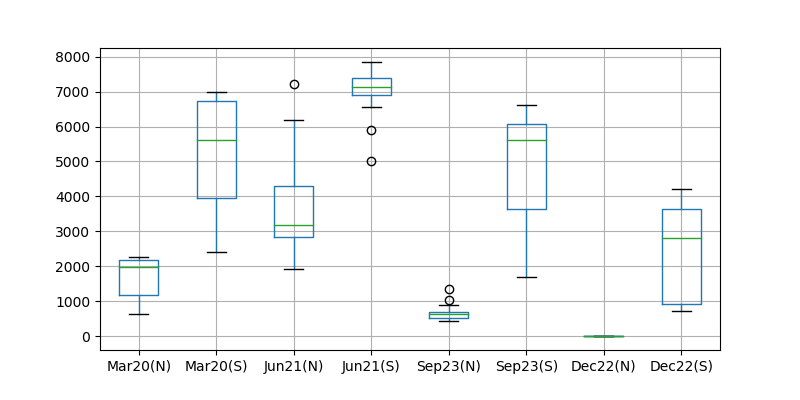


In [ ]:
dfSolarDays = pd.DataFrame()

# YOUR CODE HERE
raise NotImplementedError()



In [ ]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          
# This one has no hidden tests

assert (15, 8) == dfSolarDays.shape
assert sorted(['Mar20(N)', 'Mar20(S)', 'Jun21(N)', 'Jun21(S)', 'Sep23(N)', 'Sep23(S)', 'Dec22(N)', 'Dec22(S)']) == sorted(dfSolarDays.columns)



In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
dfSolarDays.describe()

### Exercise 4
**(1.0 pts)**  
#### A different view 
We now want to plot values for an "average" year, where average is one of the central tendency measures across all years available. Since the box plot shows that for most of the sample days the mean is off center, we'll just use the **median** for our first cut.
- Fill in the function in the next cell. 
- It takes a dfSolar dataframe as input (we'll be using dfSolarNorthData and dfSolarSouthData)
- It returns a Pandas Series with the stationid as the series name
- The index must be named `DOY` (day of year). It is ok if the index starts at 0. 
- The values in each row are the median values of all the sums for that day.
- Be sure to drop leap year days (Feb 29) before developing your index
When you plot your data, it should look like this:
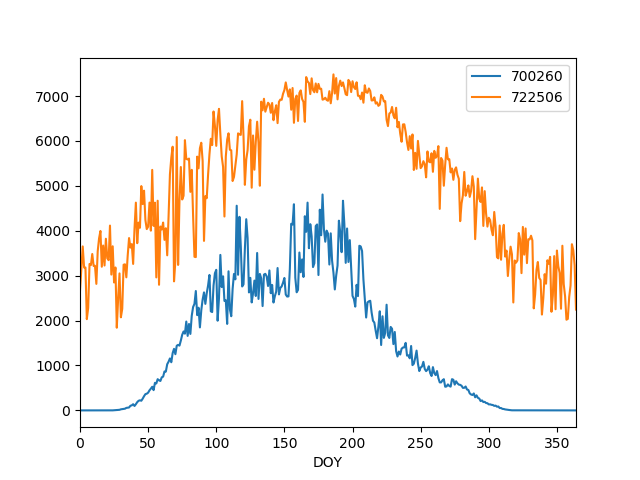


In [ ]:
def nsrb_avg_solar_year( stationid, dfSolarData ):
    # YOUR CODE HERE
    raise NotImplementedError()


In [ ]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          
# It also contains hidden tests that are run by the autograder.

srSolarNorthYear = nsrb_avg_solar_year( idSolarNorth, dfSolarNorthData )
srSolarSouthYear = nsrb_avg_solar_year( idSolarSouth, dfSolarSouthData )

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
assert srSolarSouthYear.shape == (365,)    
assert srSolarSouthYear.name == idSolarSouth
np.testing.assert_almost_equal(srSolarSouthYear[0], 2666.0, decimal=1, err_msg='Incorrect data in srSolarSouthYear', verbose=True)
np.testing.assert_almost_equal(srSolarNorthYear[128], 2890.0, decimal=1, err_msg='Incorrect data in srSolarNorthYear', verbose=True)



In the plot below, you get 0.25 points for the correct lines, 0.25 points for axis labeled and legend present with correct values. Both should happen automatically if you have the dataframe correct.

In [ ]:
# Combine srSolarNorthYear and srSolarSouthYear into a dataframe and plot a line graph
h3fig = plt.figure(num=2, figsize=[8,4], dpi=100, clear=True)
dfSolarYear = pd.DataFrame()
# YOUR CODE HERE
raise NotImplementedError()


### Exercise 5 
**(0.5 pts)**  
#### Find the weather stations closest to each of the identified solar stations.  

To do this, you will need to write the function: find_closest_weather_station
- Return a series with the stationid as the index, distance as the value
- The series must be sorted on the distance, with smallest first
- Use the utl.haversine_km() function to calculate the distance between two locations. 
- If you calculate the distance from the given solar station to all weather stations, this can take a long time. You can save a lot of time by using the fact that 1 degree of latitude is about 111 km. 


In [ ]:
def find_close_weather_stations( solarstationid, dist_km ):
    '''
    Finds the weather stations less than dist_km of the given solar station.
    This uses global classes nsrb and ghcn.
    Returns a series containing the candidate weather stations.
    '''
    # YOUR CODE HERE
    raise NotImplementedError()
    

In [ ]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          
# It also contains hidden tests that are run by the autograder.

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
srWeatherNorth = find_close_weather_stations(idSolarNorth, 20)
srWeatherSouth = find_close_weather_stations(idSolarSouth, 20) 

# We will be using weather data from the years 1978 to 2018. 
# Not all of the weather stations close to the solar stations
# were active during that time. We'll use the following.
idWeatherSouth = 'USC00415701'
idWeatherNorth = 'USW00027502'

assert idWeatherSouth in srWeatherSouth.index.to_list()
assert idWeatherNorth in srWeatherNorth.index.to_list()
                        
# The hidden tests check that your function works for other locations    

### Exercise 6
**(1.0 pts)**  
#### Extracting multiple years of weather data for a station
- If the station id is not valid, raise a ValueError
- If years is not a tuple with two integer values, raise a ValueError
- If there are years missing in the supplied range, just skip over them.
- If none of the years are valid, return an empty dataframe
- Call nsrb.read_weather_byyear for each year in the range and combine into a single dataframe 
- Remove all the Elements except TMIN and TMAX.
- The resulting dataframe should have columns: `['WeatherStnId', 'Date',  'Element', 'Value', 'Year', 'Month', 'Day']`
- Use the following format for your cache file name
  - sCacheFile = `'weatherdata-{}-{}-{}'.format(stationid,years[0],years[1])`



In [ ]:
def ghcn_aggregate_weather_data( stationid, years, savedir='.' ):
    '''
    Aggregate the weather data for specific station for a range years.
    stationid is the weather station identifier
    years is a tuple with the year range, inclusive. (firstyear, lastyear)
    '''
    # YOUR CODE HERE
    raise NotImplementedError()


In [ ]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          


# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
# To test, we are using a weather station that is present in old files, which are shorter.
sCacheFile = 'weatherdata-CA006119064-1900-1902.pqt'
if os.path.exists(sCacheFile):
    os.remove(sCacheFile)
years = (1900,1902)
dfw = ghcn_aggregate_weather_data( 'CA006119064', years )
assert (2190,7) == dfw.shape
del dfw


In [ ]:
# These are the hidden tests that are run by the autograder.

Since aggregating the weather for a single station over a 20 year period takes a long time (> 30 minutes), the next assignment will come with two cached files containing the necessary data. They were produced using the code below. You can copy this into a new cell and try it if you want to, but DO NOT leave it in your submission!!!!!!!!!!

In [ ]:
years = (1763,2018)
# Uncommenting the following lines would accumulate all of the weather data for these two stations.
# That would take a few hours...
#ghcn_aggregate_weather_data( idWeatherNorth, years )
#ghcn_aggregate_weather_data( idWeatherSouth, years )

## References
1. [Solar Radiation Measurements Workshop](https://www.nrel.gov/docs/gen/fy04/36831p.pdf), National Renewable Energy Laboratory, Aug. 2004.
2. Stoffel, Tom, [State of the Practice for Diffuse Solar Irradiance Measurements](https://www.nrel.gov/pv/assets/pdfs/2015_pvmrw_171_stoffel.pdf), Feb. 2015.